In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
import glob

import matplotlib.gridspec as gridspec

In [2]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [3]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)
#wpod_net.summary()

Loading model successfully...


In [4]:
def preprocess_image(image_path,resize=False, resize_size = (224,224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    
    #print(img.shape)
    if resize:
        img = cv2.resize(img, resize_size, interpolation=cv2.INTER_NEAREST)
    return img

In [5]:
def read_video():
    cam = cv2.VideoCapture('../../cam_1.mp4') 
        # frame 
    currentframe = 0
    frame_list = []

    while(True): 

        # reading from frame 
        ret,frame = cam.read() 

        if ret: 
            # if video is still left continue creating images 
            #name = './data/frame' + str(currentframe) + '.jpg'
            #print ('Creating...' + name) 

            # writing the extracted images 
            #cv2.imwrite(name, frame) 
            rgb_frame = cv2.cvtColor(frame.astype(np.float32), cv2.COLOR_BGR2RGB)
            frame_list.append(rgb_frame/255)

            # increasing counter so that it will 
            # show how many frames are created 
            currentframe += 1
        else: 
            break

    # Release all space and windows once done 
    cam.release() 
    
    return frame_list


frame_list = read_video()
print(len(frame_list))

106


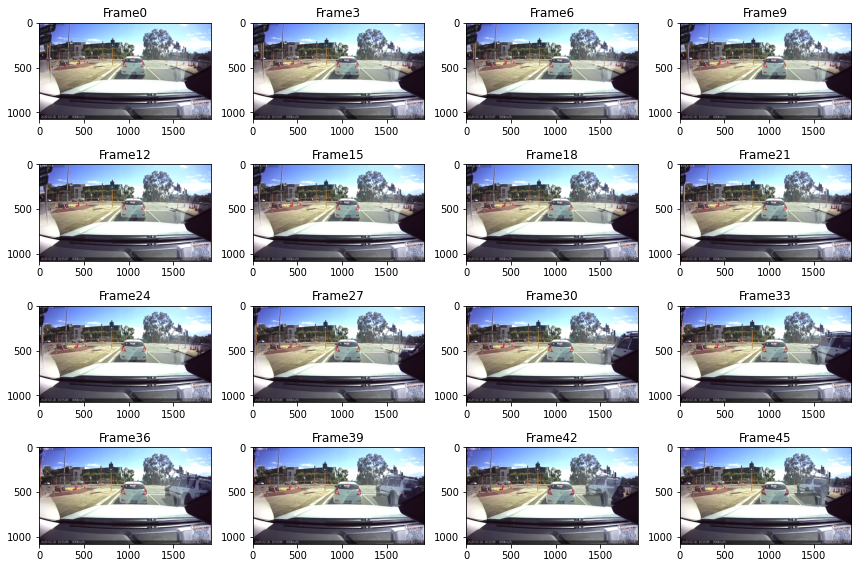

In [6]:
# Visualize data in subplot 
fig = plt.figure(figsize=(12,8))
cols = 4
rows = 4
#fig_list = []
for i in range(cols*rows):
    #fig_list.append(fig.add_subplot(rows,cols,i+1))
    #title = splitext(basename(image_paths[i]))[0]
    #print(title)
    #fig_list[-1].set_title(title)
    #img = preprocess_image(image_paths[i],True)
    index = i*3
    img = frame_list[index]
    title ='Frame' + str(index) 
    plt.subplot(rows,cols,i+1)
    plt.title(title)
    #plt.axis(False)
    plt.imshow(img)

plt.tight_layout(True)
plt.show()

In [7]:
def get_plate_by_filename(image_path, Dmax=608, Dmin=1200, resize = False, resize_size = (224,224)):
    vehicle = preprocess_image(image_path, resize= resize, resize_size = resize_size)
    #print(f'Vehicle shape : {vehicle.shape}')
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

In [8]:
# forward image through model and return plate's image and coordinates
# if error "No Licensese plate is founded!" pop up, try to adjust Dmin
def get_plate(vehicle, Dmax=608, Dmin=1200, resize = False, resize_size = (224,224)):
    
    #print(f'Vehicle shape : {vehicle.shape}')
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor


In [9]:
def per_center_crop(img,per):
    
    h,w = img.shape[0], img.shape[1]
    w2 = round(w*per/100)
    h2 = round(h*per/100)
    print(w,h,w2,h2)
    return img[h2:h-h2, w2:w-w2, :]

def per_allsides_crop(img,allper):
    
    h,w = img.shape[0], img.shape[1]
    w1 = round(w*allper[0]/100)
    w2 = round(w*allper[1]/100)
    h1 = round(h*allper[2]/100)
    h2 = round(h*allper[3]/100)
    print(w1,h1,w2,h2)
    return img[h1:h-h2, w1:w-w2,  :]

Orig Image shape : (1080, 1920, 3)
Crop Image shape : (1080, 1920, 3)


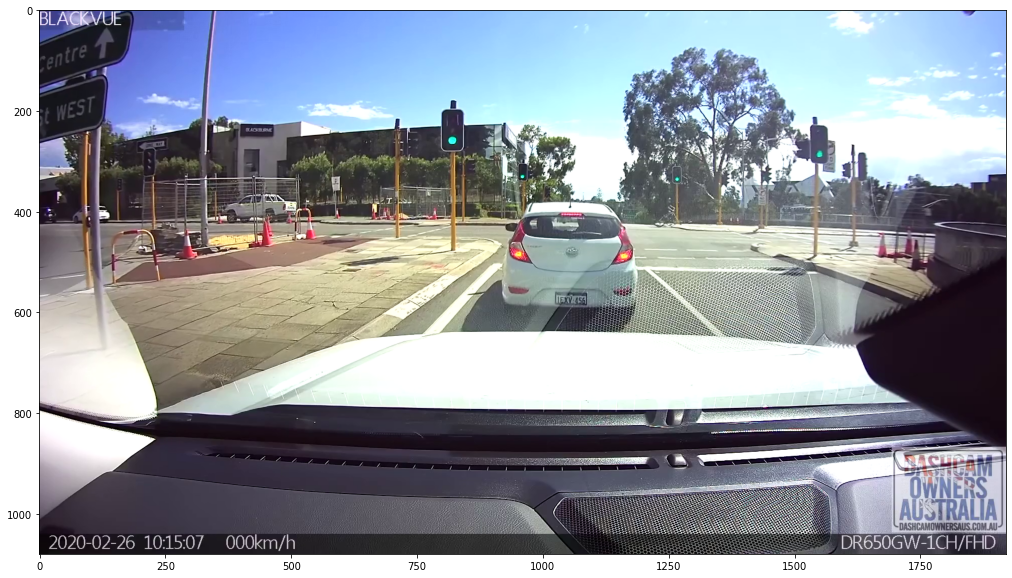

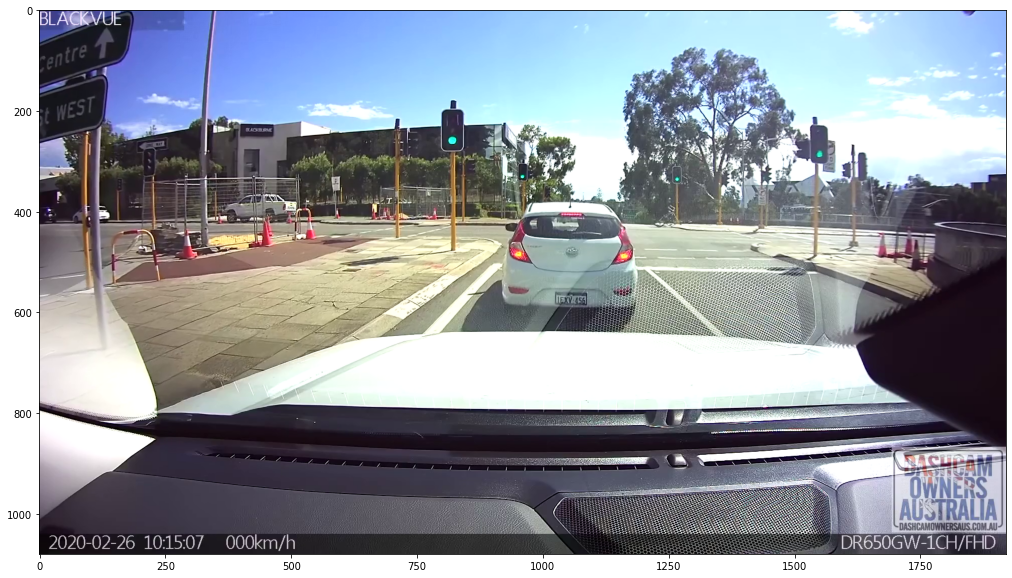

In [10]:
orig_img = frame_list[2]

per = 40
crop_orig_img = orig_img
#crop_orig_img = per_center_crop(orig_img,per)
#crop_orig_img = per_allsides_crop(orig_img,[0,50,30,10])
#crop_orig_img = per_allsides_crop(orig_img,[45,40,30,40])
print(f'Orig Image shape : {orig_img.shape}')
print(f'Crop Image shape : {crop_orig_img.shape}')

plt.figure(num=1, figsize=(30,10))
plt.imshow(orig_img)
plt.figure(num=2, figsize=(30,10))
plt.imshow(crop_orig_img)

Iresize shape : (608, 608, 3)
No plate detected in resize = 500
Iresize shape : (608, 608, 3)
No plate detected in resize = 550
Iresize shape : (608, 608, 3)
No plate detected in resize = 600
Iresize shape : (608, 608, 3)
Detect 2 plate(s) in resize = 650


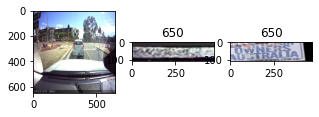

Iresize shape : (608, 608, 3)
No plate detected in resize = 700
Iresize shape : (608, 608, 3)
Detect 1 plate(s) in resize = 750


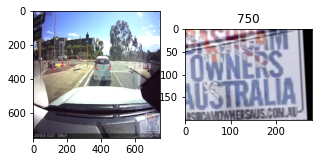

Iresize shape : (608, 608, 3)
No plate detected in resize = 800
Iresize shape : (608, 608, 3)
Detect 1 plate(s) in resize = 850


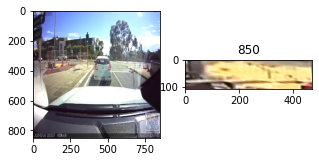

Iresize shape : (608, 608, 3)
Detect 1 plate(s) in resize = 900


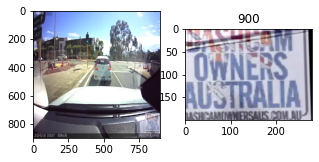

Iresize shape : (608, 608, 3)
Detect 2 plate(s) in resize = 950


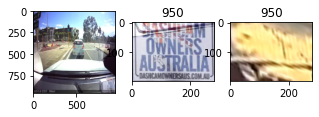

In [11]:
for rescnt, res in enumerate(range(500,1000,50)):
    resize_size = (res,res)
    #print(f'Resize dimensions : {resize_size}')
    crop_orig_img_copy = crop_orig_img    
    resized_img = cv2.resize(crop_orig_img_copy, resize_size, interpolation=cv2.INTER_NEAREST)

    vehicle, LpImg, cor = get_plate(resized_img)
    
    if (LpImg != None):
        print(f"Detect {len(LpImg)} plate(s) in resize = {res}")
        #print("Coordinate of plate(s) in image: \n", cor)
        plt.figure(num = rescnt, figsize = (5,5))
        
        plt.subplot(1,len(LpImg)+1,1)
        plt.imshow(vehicle)            
        for i in range(0,len(LpImg)):
            plt.subplot(1,len(LpImg)+1,i+2)
            plt.title(str(res))
            #plt.axis(False)
            plt.imshow(LpImg[i])
        plt.show()
    else:
        print(f'No plate detected in resize = {res}')


# RESIZE to 300, and then test

## Part 2: Segementing license characters

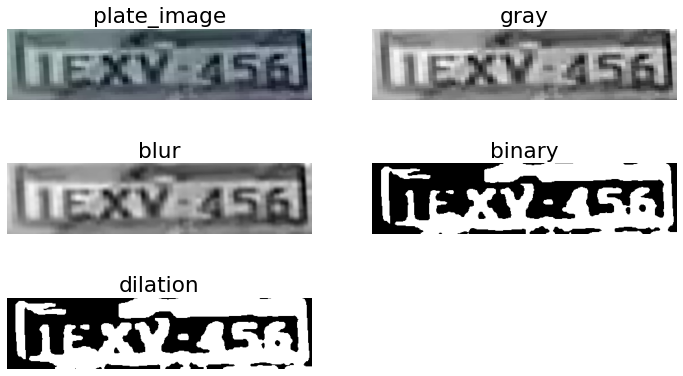

In [12]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)

[14, 7, 76, 87]
[35, 0, 435, 110]
[114, 43, 12, 6]
[147, 108, 2, 2]
[162, 75, 14, 13]
[264, 57, 15, 8]
[304, 107, 3, 3]
[390, 68, 9, 13]
[410, 64, 13, 13]
Detect 1 letters...


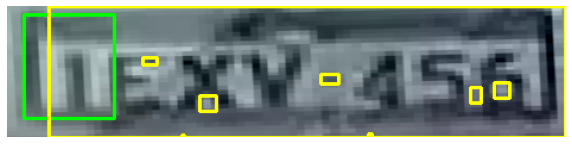

In [13]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts,reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts

cont, _  = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
#cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    print([x,y,w,h])
    cv2.rectangle(test_roi, (x, y), (x + w, y + h), (255, 255,0), 2)
    
    ratio = h/w
    if 1<=ratio<=3.5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.5: # Select contour which has the height larger than 50% of the plate
            # Draw bounding box arroung digit number
            cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

            # Sperate number and gibe prediction
            curr_num = thre_mor[y:y+h,x:x+w]
            curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
            _, curr_num = cv2.threshold(curr_num, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

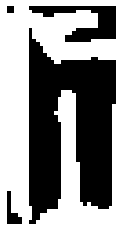

In [52]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)    

## Bonus!

Model input shape : (608, 1156, 3)
Detect 2 plate(s) in multiple_plates


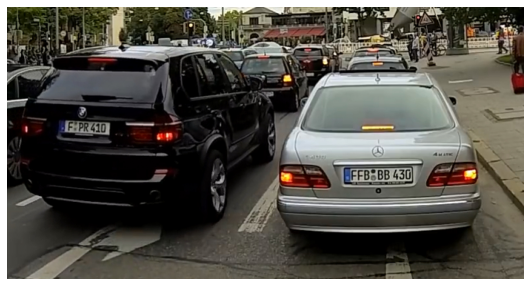

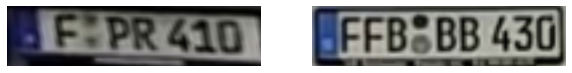

In [53]:
# Extract mutiple plate license in one image 

multiple_plates_image = "Plate_examples/multiple_plates.png"
vehicle, LpImg,cor = get_plate_by_filename(multiple_plates_image)

print("Detect %i plate(s) in"%len(LpImg),splitext(basename(multiple_plates_image))[0])

# Visualize the original image
plt.figure(figsize=(10,5))
plt.axis(False)
plt.imshow(preprocess_image(multiple_plates_image))

# Visualize the obtained plates
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(LpImg[1])
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])



## The End!